## TVB-Framework command initialisation

In [1]:
import os
from collections import OrderedDict
import time
import numpy as np

from tvb.basic.profile import TvbProfile
TvbProfile.set_profile(TvbProfile.LIBRARY_PROFILE)

from tvb_multiscale.tvb_nest.config import *

work_path = os.getcwd()
data_path = work_path
tvb_conn_filepath = os.path.join(data_path, "Connectivity_res100_596_regions.h5")
outputs_path = os.path.join(work_path, "outputs/cereb")
config = Config(output_base=outputs_path)

config.figures.SHOW_FLAG = True 
config.figures.SAVE_FLAG = True
config.figures.FIG_FORMAT = 'png'
config.figures.DEFAULT_SIZE= config.figures.NOTEBOOK_SIZE
FIGSIZE = config.figures.DEFAULT_SIZE

from tvb_multiscale.core.plot.plotter import Plotter
plotter = Plotter(config.figures)

WEIGHTED_AVERAGE_CENTRES = True

TRACT_LENGTHS_MODE = "weighted_average"  # "weighted_average", "euclidean"
# "average" is not correct at all for tract lenghts,
# because we are merging recursively one major structure after the other,
# which could work only if the merged regions have a larger weights in a weighted average, 
# for subsequent mergings of other regions.


# For interactive plotting:
# %matplotlib notebook  

# Otherwise:
%matplotlib inline 

2022-08-23 13:28:17,958 - INFO - tvb_multiscale.tvb_nest.config - Loading a NEST instance...
2022-08-23 13:28:17,958 - INFO - tvb_multiscale.tvb_nest.config - Loading a NEST instance...
2022-08-23 13:28:17,961 - INFO - tvb_multiscale.tvb_nest.config - NEST_INSTALL_DIR: /home/docker/env/neurosci/nest_build
2022-08-23 13:28:17,961 - INFO - tvb_multiscale.tvb_nest.config - NEST_INSTALL_DIR: /home/docker/env/neurosci/nest_build
2022-08-23 13:28:17,965 - INFO - tvb_multiscale.tvb_nest.config - NEST_DATA_DIR: /home/docker/env/neurosci/nest_build/share/nest
2022-08-23 13:28:17,965 - INFO - tvb_multiscale.tvb_nest.config - NEST_DATA_DIR: /home/docker/env/neurosci/nest_build/share/nest
2022-08-23 13:28:17,967 - INFO - tvb_multiscale.tvb_nest.config - NEST_DOC_DIR: /home/docker/env/neurosci/nest_build/share/doc/nest
2022-08-23 13:28:17,967 - INFO - tvb_multiscale.tvb_nest.config - NEST_DOC_DIR: /home/docker/env/neurosci/nest_build/share/doc/nest
2022-08-23 13:28:17,969 - INFO - tvb_multiscale.tv

# This loads the just-prepared data:

In [2]:
import h5py
from tvb.datatypes.connectivity import Connectivity

# Load connnectivity from file:
f = h5py.File(tvb_conn_filepath)
# We have to transpose the square connectivity matrices for TVB, because of the conversion w_ij => w_i<-j
result_connectivity = Connectivity(weights=np.array(f["weights"][()]).T, 
                                   tract_lengths=np.array(f["tract_lengths"][()]).T, 
                                   centres=np.array(f["centres"][()]), # hemispheres=np.array(f["hemispheres"][()]),
                                   region_labels=np.array(f["region_labels"][()]).astype("<U128"))
f.close()

# For the full connectome, self-connections are meaningless:
np.fill_diagonal(result_connectivity.weights, 0.0)
np.fill_diagonal(result_connectivity.tract_lengths, 0.0)

result_connectivity.configure()

print('number_of_regions:\n', result_connectivity.number_of_regions)
print('\nweights.shape:\n', result_connectivity.weights.shape)
print('\ntract_lengths.shape:\n', result_connectivity.tract_lengths.shape)
print('\nregion_labels:\n', result_connectivity.region_labels)
print('\nweights:\n', result_connectivity.weights)




number_of_regions:
 596

weights.shape:
 (596, 596)

tract_lengths.shape:
 (596, 596)

region_labels:
 ['Right Frontal pole, cerebral cortex' 'Right Primary motor area'
 'Right Secondary motor area' 'Right Primary somatosensory area, nose'
 'Right Primary somatosensory area, barrel field'
 'Right Primary somatosensory area, lower limb'
 'Right Primary somatosensory area, mouth'
 'Right Primary somatosensory area, upper limb'
 'Right Primary somatosensory area, trunk'
 'Right Primary somatosensory area, unassigned'
 'Right Supplemental somatosensory area' 'Right Gustatory areas'
 'Right Visceral area' 'Right Dorsal auditory area'
 'Right Primary auditory area' 'Right Posterior auditory area'
 'Right Ventral auditory area' 'Right Anterolateral visual area'
 'Right Anteromedial visual area' 'Right Lateral visual area'
 'Right Primary visual area' 'Right Posterolateral visual area'
 'Right posteromedial visual area' 'Right Laterointermediate area'
 'Right Postrhinal area' 'Right Anterior c

## Summarize the major structures, except for the cerebellum

In [3]:
# Open the xls file and create a mapping between all regions and the major structures they belong each.

#pip install xlrd
try:
    import xlrd
except:
    import sys
    !{sys.executable} -m pip install xlrd
    import xlrd
    
sheet_data = []   
wb = xlrd.open_workbook(os.path.join(data_path, 'oh_table1.xls'))
p = wb.sheet_names()
#p[1]
#for y in p:
sh = wb.sheet_by_name(p[1])
print(sh)
for rownum in range(sh.nrows):
    sheet_data.append((sh.row_values(rownum)))

found_list = []
voxel_count = []
rows_to_be_saved = []
regions_missing = []
cc=0

for j in result_connectivity.region_labels: #go over the region labels
    j=j.split(" ",1)[1]
    #let us get rid of the left or right
    a=len(found_list)
    for i in sheet_data:
        if i[3] == j: #or i[2] == "string2" or i[2] == "string3" or i[2] == "string4" or i[2] == "string5":
            found_list.append(i[4])
            if i[5]:
                voxel_count.append(int(i[5]))
            else:
                voxel_count.append(-1)
        else:
            rows_to_be_saved.append(i)
    
    b=len(found_list)
    if a == b:
        regions_missing.append(j)
        found_list.append('X')
        voxel_count.append(-1)
        print(a,b)
    
    b=len(found_list)
    cc+=1
    if b != cc:
        print(b,cc)
print("Regions missing:\n%s" % str(regions_missing))
n_regs = len(found_list)
print("Number of regions: %d" % n_regs)
n_regs2 = n_regs/2
major_structures_labels = ["Right " + msl if iL <n_regs2 else "Left " + msl 
                           for iL, msl in enumerate(found_list)]
voxel_count = np.array(voxel_count).astype('i')
major_structures = np.unique(major_structures_labels)
print("\nmajor_structures:\n", major_structures)


Sheet  1:<Voxel Count_295 Structures>
Regions missing:
[]
Number of regions: 596

major_structures:
 ['Left Cerebellar Cortex' 'Left Cerebellar Nuclei'
 'Left Cortical Subplate' 'Left Hippocampal Formation' 'Left Hypothalamus'
 'Left Isocortex' 'Left Medulla' 'Left Midbrain'
 'Left Nonspecific Thalamus' 'Left Olfactory Areas' 'Left Pallidum'
 'Left Pons Behavioral' 'Left Pons Motor' 'Left Pons Sensory'
 'Left Spinal nucleus of the trigeminal' 'Left Striatum' 'Left Thalamus'
 'Right Cerebellar Cortex' 'Right Cerebellar Nuclei'
 'Right Cortical Subplate' 'Right Hippocampal Formation'
 'Right Hypothalamus' 'Right Isocortex' 'Right Medulla' 'Right Midbrain'
 'Right Nonspecific Thalamus' 'Right Olfactory Areas' 'Right Pallidum'
 'Right Pons Behavioral' 'Right Pons Motor' 'Right Pons Sensory'
 'Right Spinal nucleus of the trigeminal' 'Right Striatum'
 'Right Thalamus']


# Find the connections FROM Isocortex nodes TO the Reticular Thalamic Nucleus and store them:

In [4]:
crtx_inds = np.where(["Isocortex" in lbl for lbl in major_structures_labels])[0]
rtn_inds = np.where(["Reticular nucleus of the thalamus" in reg for reg in result_connectivity.region_labels])[0]

crtx_to_rtn_conns = result_connectivity.weights[rtn_inds][:, crtx_inds]
print("crtx_to_rtn_conns.shape: ", crtx_to_rtn_conns.shape)
# print("\ncrtx_to_rtn_conns:\n","crtx_to_rtn_conns)

crtx_to_rtn_conns.shape:  (2, 86)


# Some functions to use for merging regions to larger structures

In [5]:
from copy import deepcopy


def voxel_count_sum(arr, axis=0, **kwargs):
    voxel_count_sum = np.sum(arr[arr>0], axis=axis)
    print("Voxel count sum: %s" % str(voxel_count_sum))
    return voxel_count_sum

    
def weighted_average(arr, axis=0, **kwargs):
    weights = kwargs.pop('weights', 1.0)
    if weights.ndim < arr.ndim:
        weights = np.expand_dims(weights, 1-axis)
    wav = np.nansum(arr * weights, axis=axis, **kwargs) / np.nansum(weights)
#     av = np.nanmean(arr, axis=axis, **kwargs)
#     print("wav = %s, av = %s,  |wav-av| = %s" % (str(wav), str(av),  str(euclidean_distance(wav, av))))
    return wav
    
    
def repeat(arr, sub, axis=0, **kwargs):
    """This function will tile a subarray
       to create an array of shape similar to the input array's arr, 
       except for the axis given in the input, where size will be 1.
       It is used to substitute many labels by a single one."""
    shape = list(arr.shape)
    shape[axis] = 1
    return np.tile(sub, tuple(shape))
    

def delete(arr, axis=0, **kwargs):
    """This function returns an empty array 
       of shape similar to the input array's arr, 
       except for the axis given in the input, where size will be 0.
       It is used to delete a subarray."""
    shape = list(arr.shape)
    shape[axis] = 0
    return np.empty(tuple(shape))


def insert_axis(arr, arr_to_insert=None, inds=None, axis=0, def_value=0.0):
    if inds is None:
        inds = [arr.shape[axis]]
    if arr_to_insert is None:
        arr_to_insert = np.tile(def_value, np.take(arr, [-1], axis=axis).shape)
    return np.insert(arr, inds, arr_to_insert, axis=axis)


def merge_axis(inds, arr, axis=0, fun=np.nansum, **funkwargs):
    """This function will merge a subarray of the input array arr,
       as defined by the input indices inds, along the input axis,
       applying the function fun, in order to summarize the values."""
    new_arr = np.delete(arr, inds, axis)
    array_to_be_merged = np.take(arr, inds, axis)
    if funkwargs.get('weights', None) is not None:
        # we need to reduce weights just like arr
        funkwargs['weights'] = np.take(funkwargs['weights'], inds, axis=axis)
    merged_arr = fun(array_to_be_merged, axis, keepdims=True, **funkwargs)
    return insert_axis(new_arr, merged_arr, [np.minimum(inds[0], new_arr.shape[axis])], axis=axis)
    # return np.insert(new_arr, [np.minimum(inds[0], new_arr.shape[axis])], merged_arr, axis=axis)
    
    
def merge_nD(inds, arr, fun=np.nansum, weights=None, **funkwargs):
    """This function will merge a subarray of the input array arr,
       as defined by the input indices inds, 
       along all the axes of arr (assuming same dimensionality along all axes),
       applying the function fun, in order to summarize the values."""
    new_arr = arr.copy()
    for ax in range(arr.ndim):
        if weights is not None:
            new_arr = merge_axis(inds, new_arr, axis=ax, fun=fun, weights=weights, **funkwargs)
            # we need to reduce weights just like arr
            weights = merge_axis(inds, weights, axis=ax, fun=np.nansum)
        else:
            new_arr = merge_axis(inds, new_arr, axis=ax, fun=fun, **funkwargs)
    return new_arr


def euclidean_distance(p1, p2, axis=1):
    return np.sum(np.square(p1 - p2),  axis=axis)


def compute_euclidean_tract_lengths(centres):
    N = centres.shape[0]
    tl = np.zeros((N, N))
    for iR1 in range(N-1):
        for iR2 in range(iR1+1, N):
            tl[iR1, iR2] = euclidean_distance(centres[iR1][np.newaxis], centres[iR2][np.newaxis])
            tl[iR2, iR1] = tl[iR1, iR2]
    return tl        
            
    
def merge_conn(conn, regions, new_label, voxel_count, 
               weight_fun=np.nansum, configure=False):
    """This function will merge an input TVB connectivity conn, 
       for the input regions (indices or labels), 
       substituting them with a summarized region of label new_label, 
       applying the summary function for the connectivity weights weight_fun.
       If configure is True, the new connectivity will also be configured."""
    if np.issubdtype(regions.dtype, np.integer):
        inds = regions
    else:
        inds = []
        for iR, region in conn.region_labels:
            if region in regions:
                inds.append(iR)
    new_conn = deepcopy(conn)
    repeat_fun = lambda arr, axis=0, **kwargs: repeat(arr, new_label, axis, **kwargs)
    new_conn.region_labels = merge_axis(inds, conn.region_labels, axis=0, fun=repeat_fun)
    new_conn.weights = merge_nD(inds, conn.weights, fun=weight_fun)
    # If WEIGHTED_AVERAGE_CENTRES...
    if WEIGHTED_AVERAGE_CENTRES:
        # ...compute merged regions' centres as weighted averages of the component regions' centres
        # weighted by the relative volume (i.e., voxel count) of each region:
        new_conn.centres = merge_axis(inds, conn.centres, axis=0, fun=weighted_average, weights=voxel_count)
    else: # ...otherwise...
        # ...approximate merged regions' centres as simple averages of the component regions' centres
        new_conn.centres = merge_axis(inds, conn.centres, axis=0, fun=np.nanmean)
    if TRACT_LENGTHS_MODE == "euclidean":
        # Compute tract lengths as euclidean distances from the newly formed merged regions' centres:
        new_conn.tract_lengths = compute_euclidean_tract_lengths(new_conn.centres)
    else:
        # Compute tract lengths as weighted averages of the tract lengths 
        # of all connections referring to/from a merged region, 
        # weighted by corresponding tracts' weights:
        new_conn.tract_lengths = merge_nD(inds, conn.tract_lengths, fun=weighted_average, weights=conn.weights)
    if configure:
        new_conn.configure()
    return new_conn

    
def merge_major_structure(conn, major_struct_to_merge, major_structs_labels, voxel_count,
                          exclude_regions=[], weight_fun=np.nansum, configure=False):
    """This function will merge an input TVB connectivity conn, 
       for the input major structure label major_struct_to_merge,
       assuming an input vector major_structs_labels, mapping all regions to a major structure,
       substituting merged regions with a summarized region of the major structure label, 
       and applying the summary function for the connectivity weights weight_fun.
       If configure is True, the new connectivity will also be configured."""
    regions_inds = np.where([major_structs_label == major_struct_to_merge and 
                             region not in exclude_regions 
                             for region, major_structs_label in zip(conn.region_labels, major_structs_labels)])[0]
    print("...%d regions' indices of %s:\n%s" % (len(regions_inds), major_struct_to_merge, str(regions_inds)))
    repeat_fun = lambda arr, axis=0, **kwargs: repeat(arr, major_struct_to_merge, axis, **kwargs)
    return merge_conn(conn, regions_inds, major_struct_to_merge, voxel_count,
                      weight_fun=weight_fun, configure=configure), \
           merge_axis(regions_inds, major_structs_labels, axis=0, fun=repeat_fun), \
           merge_axis(regions_inds, voxel_count, axis=0, fun=voxel_count_sum)
    
    
def merge_major_structures(conn, major_structs_to_merge, major_structs_labels, voxel_count, 
                           exclude_regions={}, weight_fun=np.nansum):
    """This function will merge an input TVB connectivity conn, 
       for the input major structures labels major_structs_to_merge,
       assuming an input vector major_structs_labels, mapping all regions to a major structure,
       substituting merged regions with a summarized region of the respective major structure label, 
       and applying the summary function for the connectivity weights weight_fun.
       If configure is True, the new connectivity will also be configured."""
    new_conn = deepcopy(conn)
    new_major_structs_labels = major_structs_labels.copy()
    new_voxel_count = voxel_count.copy()
    for major_struct_to_merge in major_structs_to_merge:
        print("Merging %s ..." % major_struct_to_merge)
        new_conn, new_major_structs_labels, new_voxel_count = \
            merge_major_structure(new_conn, major_struct_to_merge, 
                                  new_major_structs_labels, new_voxel_count, 
                                  exclude_regions=exclude_regions.get(major_struct_to_merge, []), 
                                  weight_fun=weight_fun)
        
    new_conn.configure()
    return new_conn, new_major_structs_labels, new_voxel_count



In [6]:
def unilateral_to_bilateral_exclude_regions(major_structure, hemi, exclude_regions):
    new_exclude_regions = []
    if len(exclude_regions):
        if hemi == "Left":
            hemistr = "Left "
            hemidel = "Right "
        else:
            hemistr = "Right "
            hemidel = "Left "
        for reg in exclude_regions:
            if hemistr in reg:
                new_exclude_regions.append(reg)
            elif hemidel in reg:
                pass
            else:
                new_exclude_regions.append(hemistr + reg)
    return new_exclude_regions


    
def unilateral_to_bilateral(major_structures_to_merge, exclude_regions):
    # For bilateral merge: 
    new_major_structures_to_merge = []
    new_exclude_regions = {}
    for mstm in major_structures_to_merge:
        if "Left " not in mstm and "Right " not in mstm:
            left = "Left " + mstm
            new_major_structures_to_merge.append("Left " + mstm)
            new_major_structures_to_merge.append("Right " + mstm)
        else:
            new_major_structures_to_merge.append(mstm)
    new_major_structures_to_merge = np.unique(new_major_structures_to_merge)
    for hemimstm in new_major_structures_to_merge:
        if "Left " in hemimstm:
            hemi = "Left"
            mstm = hemimstm.split("Left ")[-1]
        else:
            hemi = "Right"
            mstm = hemimstm.split("Right ")[-1]
        new_exclude_regions[hemimstm] = \
            exclude_regions.get(hemimstm, 
                                unilateral_to_bilateral_exclude_regions(mstm, hemi, exclude_regions.get(mstm, [])))
    return new_major_structures_to_merge, new_exclude_regions

    

# Determine regions and structures to be merged, uni- and/or bi-laterally

In [7]:
# Summarize all subcortical major structures except for the Cerebellar Cortices and Nuclei 
# for _SummedSubcortical connectomes.
# Specific Thalami have to be merged and then distributed to the Isocortex nodes in any case:
major_structures_to_merge = ['Thalamus', 
                             'Cortical Subplate', 'Hippocampal Formation',  'Hypothalamus', 
                             'Medulla','Spinal nucleus of the trigeminal', 
                             'Midbrain', 'Olfactory Areas', 'Pallidum', 
                             'Pons Motor', 'Pons Sensory', 'Pons Behavioral', 
                             'Striatum', 'Cerebellar Cortex', 'Cerebellar Nuclei', 'Nonspecific Thalamus', 
                            ] 

exclude_regions = {'Cerebellar Cortex': ["Ansiform lobule"], 
                   'Cerebellar Nuclei': ["Interposed nucleus"], 
                   'Medulla': ["Inferior olivary complex", "Facial motor nucleus"],
                   'Pons Sensory': ["Principal sensory nucleus of the trigeminal"], 
                   'Midbrain': ["Superior colliculus, motor related"]}

# For bilateral merging:
major_structures_to_merge, exclude_regions = unilateral_to_bilateral(major_structures_to_merge, exclude_regions)

print('major_structures_to_merge:\n', major_structures_to_merge)
print('\nexclude_regions from mergin:\n', exclude_regions)

major_structures_to_merge:
 ['Left Cerebellar Cortex' 'Left Cerebellar Nuclei'
 'Left Cortical Subplate' 'Left Hippocampal Formation' 'Left Hypothalamus'
 'Left Medulla' 'Left Midbrain' 'Left Nonspecific Thalamus'
 'Left Olfactory Areas' 'Left Pallidum' 'Left Pons Behavioral'
 'Left Pons Motor' 'Left Pons Sensory'
 'Left Spinal nucleus of the trigeminal' 'Left Striatum' 'Left Thalamus'
 'Right Cerebellar Cortex' 'Right Cerebellar Nuclei'
 'Right Cortical Subplate' 'Right Hippocampal Formation'
 'Right Hypothalamus' 'Right Medulla' 'Right Midbrain'
 'Right Nonspecific Thalamus' 'Right Olfactory Areas' 'Right Pallidum'
 'Right Pons Behavioral' 'Right Pons Motor' 'Right Pons Sensory'
 'Right Spinal nucleus of the trigeminal' 'Right Striatum'
 'Right Thalamus']

exclude_regions from mergin:
 {'Left Cerebellar Cortex': ['Left Ansiform lobule'], 'Left Cerebellar Nuclei': ['Left Interposed nucleus'], 'Left Cortical Subplate': [], 'Left Hippocampal Formation': [], 'Left Hypothalamus': [], 'Lef

# Execute merging

In [8]:
new_conn, new_major_structs_labels, new_voxel_count = \
    merge_major_structures(result_connectivity, 
                           major_structures_to_merge,
                           major_structures_labels, voxel_count,
                           exclude_regions=exclude_regions, weight_fun=np.nansum)
sum_conn_new = new_conn.weights
print("\nMerged major structures and their voxel counts:\n", 
      np.array(list(zip(new_conn.region_labels, new_major_structs_labels, new_voxel_count))))

Merging Left Cerebellar Cortex ...
...13 regions' indices of Left Cerebellar Cortex:
[578 579 580 581 582 583 584 585 586 588 589 590 591]
Voxel count sum: 33696
Merging Left Cerebellar Nuclei ...
...3 regions' indices of Left Cerebellar Nuclei:
[580 582 583]
Voxel count sum: 587
Merging Left Cortical Subplate ...
...7 regions' indices of Left Cortical Subplate:
[365 366 367 368 369 370 371]
Voxel count sum: 6669
Merging Left Hippocampal Formation ...
...13 regions' indices of Left Hippocampal Formation:
[352 353 354 355 356 357 358 359 360 361 362 363 364]
Voxel count sum: 34819
Merging Left Hypothalamus ...
...41 regions' indices of Left Hypothalamus:
[419 420 421 422 423 424 425 426 427 428 429 430 431 432 433 434 435 436
 437 438 439 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454
 455 456 457 458 459]
Voxel count sum: 13871
Merging Left Medulla ...
...34 regions' indices of Left Medulla:
[481 482 483 484 485 486 490 491 493 494 495 497 498 499 500 501 502 503
 504 505 

# Testing merging

In [9]:
# Testing that everything went well:
print("Testing merging, voxel counts, sum of (self/from/to) weights, and self-tract lengths:")
for iR, (reg, msl, vc) in enumerate(zip(new_conn.region_labels, new_major_structs_labels, new_voxel_count)):
    print("\n%s - %s:" % (reg, msl))
    if reg in result_connectivity.region_labels:
        iR2 = np.where([reg == reg2 for reg2 in result_connectivity.region_labels])[0]
        print("...%d = %d voxels" % (vc, voxel_count[iR2]))
        assert voxel_count[iR2] - vc == 0
        print("...centres: %s = %s" % (new_conn.centres[iR], result_connectivity.centres[iR2]))
        assert np.allclose(new_conn.centres[iR], result_connectivity.centres[iR2])
        ws = np.nansum(new_conn.weights[iR])
        ws2 = np.nansum(result_connectivity.weights[iR2])
        print("...weights to: %g = %g" % (ws, ws2))
        assert np.abs(ws - ws2) < 1e-6
        ws = np.nansum(new_conn.weights[:, iR])
        ws2 = np.nansum(result_connectivity.weights[:, iR2])
        print("...weights from: %g = %g" % (ws, ws2))
        assert np.abs(ws - ws2) < 1e-6
        print("...self tract_lengths: %g = %g" % (new_conn.tract_lengths[iR, iR], result_connectivity.tract_lengths[iR, iR]))
        assert np.abs(new_conn.tract_lengths[iR, iR] - result_connectivity.tract_lengths[iR, iR]) < 1e-6
    else:
        excl_regs = exclude_regions.get(reg, [])
        iR2s = np.where([msl == msl2 and reg2 not in excl_regs
                         for reg2, msl2 in zip(result_connectivity.region_labels, major_structures_labels)])[0]
        old_vc = voxel_count[iR2s]
        old_vc = old_vc[old_vc >= 0]
        old_vc_sum = old_vc.sum()
        print("...%d voxels" % old_vc_sum)
        assert old_vc_sum - vc == 0
        if WEIGHTED_AVERAGE_CENTRES:
            assert np.allclose(new_conn.centres[iR], 
                               np.average(result_connectivity.centres[iR2s, :], 
                                          axis=0, weights=voxel_count[iR2s])) # , keepdims=True))
        else:
            oldcntrs = np.nanmean(result_connectivity.centres[iR2s], axis=0)
            print("...centres: %s = %s" % (new_conn.centres[iR], oldcntrs))
            assert np.allclose(new_conn.centres[iR], oldcntrs)
        ws = np.nansum(new_conn.weights[iR])
        ws2 = np.nansum(result_connectivity.weights[iR2s])
        print("...weights to: %g = %g" % (ws, ws2))
        assert np.abs(ws - ws2) < 1e-6
        ws = np.nansum(new_conn.weights[:, iR])
        ws2 = np.nansum(result_connectivity.weights[:, iR2s])
        print("...weights from: %g = %g" % (ws, ws2))
        assert np.abs(ws - ws2) < 1e-6
        ws2 = np.nansum(result_connectivity.weights[iR2s][:, iR2s])
        print("...self weights: %g = %g" % (new_conn.weights[iR, iR], ws2))
        assert np.abs(new_conn.weights[iR, iR] - ws2) < 1e-6
        if TRACT_LENGTHS_MODE == "euclidean":
            tl = new_conn.tract_lengths[iR, :]
            tl2 = euclidean_distance(new_conn.centres[iR, :], new_conn.centres)
            print("...average tract_lengths to/from: %g = %g" % (tl.mean(), tl2.mean()))
            assert np.allclose(tl, tl2)
        # TODO: Think of a test for weigthed average!!!
           
            
        
        

Testing merging, voxel counts, sum of (self/from/to) weights, and self-tract lengths:

Right Frontal pole, cerebral cortex - Right Isocortex:
...514 = 514 voxels
...centres: [45.5942029  22.72256729 51.2484472 ] = [[45.5942029  22.72256729 51.2484472 ]]
...weights to: 3.14868 = 3.14868
...weights from: 6.36079 = 6.36079
...self tract_lengths: 0 = 0

Right Primary motor area - Right Isocortex:
...11760 = 11760 voxels
...centres: [35.30080448 42.96502274 55.40433718] = [[35.30080448 42.96502274 55.40433718]]
...weights to: 1.87382 = 1.87382
...weights from: 6.37274 = 6.37274
...self tract_lengths: 0 = 0

Right Secondary motor area - Right Isocortex:
...10098 = 10098 voxels
...centres: [43.65873016 36.05326618 57.91804029] = [[43.65873016 36.05326618 57.91804029]]
...weights to: 2.33534 = 2.33534
...weights from: 6.99391 = 6.99391
...self tract_lengths: 0 = 0

Right Primary somatosensory area, nose - Right Isocortex:
...1358 = 1358 voxels
...centres: [21.02302632 56.74407895 54.42039474] 

...weights to: 1.3537 = 1.3537
...weights from: 5.09649 = 5.09649
...self tract_lengths: 0 = 0

Left Primary somatosensory area, upper limb - Left Isocortex:
...5406 = 5406 voxels
...centres: [81.3455804  54.61182109 61.69755059] = [[81.3455804  54.61182109 61.69755059]]
...weights to: 1.39079 = 1.39079
...weights from: 2.70357 = 2.70357
...self tract_lengths: 0 = 0

Left Primary somatosensory area, trunk - Left Isocortex:
...4799 = 4799 voxels
...centres: [75.04409673 66.81507824 69.51920341] = [[75.04409673 66.81507824 69.51920341]]
...weights to: 2.32431 = 2.32431
...weights from: 4.8304 = 4.8304
...self tract_lengths: 0 = 0

Left Primary somatosensory area, unassigned - Left Isocortex:
...2958 = 2958 voxels
...centres: [84.93838863 58.57661927 61.72827804] = [[84.93838863 58.57661927 61.72827804]]
...weights to: 1.71146 = 1.71146
...weights from: 3.56411 = 3.56411
...self tract_lengths: 0 = 0

Left Supplemental somatosensory area - Left Isocortex:
...5729 = 5729 voxels
...centres: 

# Plot merged connectome

/tmp/ipykernel_1302/2993400780.py:10: RuntimeWarning: divide by zero encountered in log10
  cs_log = axes[0, 1].imshow(np.log10(new_conn.weights), cmap='jet', aspect='equal', interpolation='none')
/tmp/ipykernel_1302/2993400780.py:20: RuntimeWarning: divide by zero encountered in log10
  ls_log = axes[1, 1].imshow(np.log10(new_conn.tract_lengths), cmap='jet', aspect='equal', interpolation='none')


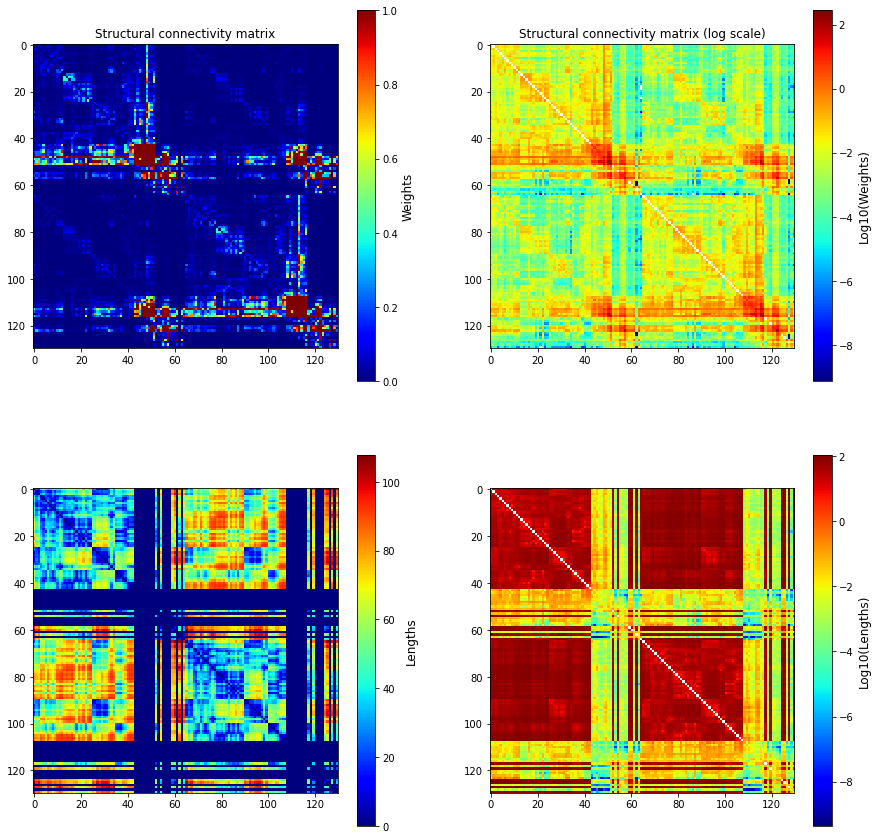

In [10]:
# Plot the resulting connectivity weights at linear and log scale
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(15, 15))
cs_lin = axes[0, 0].imshow(new_conn.weights, cmap='jet', aspect='equal', interpolation='none', vmax=1)
axes[0, 0].set_title('Structural connectivity matrix', fontsize=12)
axcb_lin = plt.colorbar(cs_lin, ax=axes[0, 0])
axcb_lin.set_label('Weights', fontsize=12)

cs_log = axes[0, 1].imshow(np.log10(new_conn.weights), cmap='jet', aspect='equal', interpolation='none')
axes[0, 1].set_title('Structural connectivity matrix (log scale)', fontsize=12)
axcb_log = plt.colorbar(cs_log, ax=axes[0, 1])
axcb_log.set_label('Log10(Weights)', fontsize=12)


ls_lin = axes[1, 0].imshow(new_conn.tract_lengths, cmap='jet', aspect='equal', interpolation='none')
axcb_lin = plt.colorbar(ls_lin, ax=axes[1, 0])
axcb_lin.set_label('Lengths', fontsize=12)

ls_log = axes[1, 1].imshow(np.log10(new_conn.tract_lengths), cmap='jet', aspect='equal', interpolation='none')
axcb_log = plt.colorbar(ls_log, ax=axes[1, 1])
axcb_log.set_label('Log10(Lengths)', fontsize=12)


# Construct useful indices

In [11]:
inds = {}
inds["crtx"] = []
inds["m1"] = []
inds["s1brl"] = []
inds["supcol"] = []
inds["facial"] = []
inds["trigeminal"] = []
inds["ponssens_trigeminal"] = []
inds["ponssens"] = []
inds["ponsmotor"] = []
inds["thal"] = []
inds["thalspec"] = []
inds["m1thal"] = []
inds["s1brlthal"] = []
inds["ansilob"] = []
inds["dentate"] = []
inds["interposed"] = []
inds["oliv"] = []
inds['cereb_nuclei'] = []
inds['cereb_crtx'] = []
for iR, (reg, lbl) in enumerate(zip(new_conn.region_labels, new_major_structs_labels)):
    if "Isocortex" in lbl:
        inds["crtx"].append(iR)
    if "Primary motor area" in reg and "Specific" not in reg:
        inds["m1"].append(iR)
    if "barrel" in reg and "Specific" not in reg:
        inds["s1brl"].append(iR)
    if "Superior colliculus, motor related" in reg:
        inds["supcol"].append(iR)
    if "Primary motor area" in reg and "Specific" in reg:
        inds["m1thal"].append(iR)
    if "barrel" in reg and "Specific" in reg:
        inds["s1brlthal"].append(iR)
    if "Superior colliculus, motor related" in reg:
        inds["supcol"].append(iR)
    if "Facial" in reg:
        inds["facial"] .append(iR)
    if "Spinal nucleus of the trigeminal" in reg:
        inds["trigeminal"].append(iR)
    if "Principal sensory nucleus of the trigeminal" in reg:
        inds["ponssens_trigeminal"] .append(iR)
    if "Pons Sensory" in lbl:
        inds["ponssens"] .append(iR)
    if "Pons Motor" in lbl:
        inds["ponsmotor"].append(iR)
    if "Nonspecific Thalamus" in lbl:
        inds["thal"].append(iR)
    if "Thalamus" in lbl:
        inds["thalspec"].append(iR)
    if "Ansiform lobule" in reg:
        inds["ansilob"].append(iR)
    elif "Cerebellar Cortex" in lbl:
        inds['cereb_crtx'].append(iR)
    if "Dentate nucleus" in reg:
        inds["dentate"].append(iR)
    if "Interposed nucleus" in reg:
        inds["interposed"].append(iR)
    elif "Cerebellar Nuclei" in lbl:
        inds['cereb_nuclei'].append(iR)
    if "Inferior olivary complex" in reg:
        inds["oliv"].append(iR)
inds["m1s1brl"] = inds["m1"]  + inds["s1brl"]
inds["sens"] = inds["trigeminal"]  + inds["ponssens_trigeminal"] + inds["s1brlthal"]
inds["motor"] = inds["m1thal"] + inds["facial"]  # inds["supcol"]  + 
inds["cereb"] = inds["ansilob"] + inds["dentate"] + inds["interposed"] + inds["oliv"]
inds['cereb_merged'] = inds['cereb_nuclei'] + inds['cereb_crtx']
allspecial = inds["m1s1brl"] + inds["motor"] + inds["sens"] + inds["thal"] + inds["thalspec"] + inds["cereb"]
for key, val in inds.items():
    inds[key] = np.array(val)

print("ROIs:\n", new_conn.region_labels[allspecial])

ROIs:
 ['Right Primary motor area' 'Left Primary motor area'
 'Right Primary somatosensory area, barrel field'
 'Left Primary somatosensory area, barrel field'
 'Right Facial motor nucleus' 'Left Facial motor nucleus'
 'Right Spinal nucleus of the trigeminal'
 'Left Spinal nucleus of the trigeminal'
 'Right Principal sensory nucleus of the trigeminal'
 'Left Principal sensory nucleus of the trigeminal'
 'Right Nonspecific Thalamus' 'Left Nonspecific Thalamus' 'Right Thalamus'
 'Right Nonspecific Thalamus' 'Left Thalamus' 'Left Nonspecific Thalamus'
 'Right Ansiform lobule' 'Left Ansiform lobule' 'Right Interposed nucleus'
 'Left Interposed nucleus' 'Right Inferior olivary complex'
 'Left Inferior olivary complex']


In [12]:
import h5py

# the method returns the tract lengths between the brain areas in the selected parcellation
def construct_tract_lengths(centres):
    n_regions = len(centres)
    tracts = np.zeros((n_regions, n_regions), dtype=float)
    for i_ind, inj in enumerate(centres):
        for i_targ, targ in enumerate(centres):
            tracts[i_ind, i_targ] = np.sqrt(
                (inj[0] - targ[0]) ** 2 + (inj[1] - targ[1]) ** 2 + (inj[2] - targ[2]) ** 2)
    return tracts

def write_connectivity_to_h5_file(connectivity, filename):
    #save the structural conn matrix
    f = h5py.File(os.path.join(data_path, filename), "w")
    for attr in ["weights", "tract_lengths", "centres", "region_labels"]:
        if attr == "region_labels":
            f.create_dataset(attr, data=getattr(connectivity, attr).astype(h5py.string_dtype(encoding='utf-8')))

        else:
            f.create_dataset(attr, data=getattr(connectivity, attr))
    f.close()  
    


def write_all_files(conn_name="Connectivity", conn_type=""):
    if WEIGHTED_AVERAGE_CENTRES:
        conn_name += "_wavCntrs"
    else:
        conn_name += "_avCntrs"
    if TRACT_LENGTHS_MODE == "euclidean":
        conn_name += "_TLed"
    else:
        conn_name += "_TLwav"
    print("Writing files for SummedSubcortical Connectivity...")
    # Write the resulting connectivity to .h5 TVB compatible file...
    print("Writing %s_%s.h5" % (conn_name, conn_type))
    write_connectivity_to_h5_file(new_conn, "%s_%s.h5" % (conn_name, conn_type))
    # ... along with the corresponding mapping from regions to major structures.
    print("Writing major_structs_labels_%s.npy..." % conn_type)
    np.save("major_structs_labels_%s.npy" % conn_type, new_major_structs_labels)
    print("Writing voxel_count_%s.npy..." % conn_type)
    np.save("voxel_count_%s.npy" % conn_type, new_voxel_count)
    print("Writing inds_%s.npy..." % conn_type)
    np.save("inds_%s.npy" % conn_type, inds)
    

In [13]:
print("Major structures:\n", np.unique(new_major_structs_labels))

Major structures:
 ['Left Cerebellar Cortex' 'Left Cerebellar Nuclei'
 'Left Cortical Subplate' 'Left Hippocampal Formation' 'Left Hypothalamus'
 'Left Isocortex' 'Left Medulla' 'Left Midbrain'
 'Left Nonspecific Thalamus' 'Left Olfactory Areas' 'Left Pallidum'
 'Left Pons Behavioral' 'Left Pons Motor' 'Left Pons Sensory'
 'Left Spinal nucleus of the trigeminal' 'Left Striatum' 'Left Thalamus'
 'Right Cerebellar Cortex' 'Right Cerebellar Nuclei'
 'Right Cortical Subplate' 'Right Hippocampal Formation'
 'Right Hypothalamus' 'Right Isocortex' 'Right Medulla' 'Right Midbrain'
 'Right Nonspecific Thalamus' 'Right Olfactory Areas' 'Right Pallidum'
 'Right Pons Behavioral' 'Right Pons Motor' 'Right Pons Sensory'
 'Right Spinal nucleus of the trigeminal' 'Right Striatum'
 'Right Thalamus']


# Writing files for Connectivity with summarized subcortical structures

In [14]:
write_all_files(conn_name="Connectivity", conn_type="SummedSubcortical")


Writing files for SummedSubcortical Connectivity...
Writing Connectivity_wavCntrs_TLwav_SummedSubcortical.h5
Writing major_structs_labels_SummedSubcortical.npy...
Writing voxel_count_SummedSubcortical.npy...
Writing inds_SummedSubcortical.npy...


# Splitting Thalamus to create specific thalamic nuclei

In [15]:

# Now we need to create the specific Thalamic nuclei, one for each Isocortex node:

# Thalamus indices:
iThR = np.where(["Right Thalamus" in lbl for lbl in new_major_structs_labels])[0][0]
iThL = np.where(["Left Thalamus" in lbl for lbl in new_major_structs_labels])[0][0]
assert np.all(new_conn.region_labels[[iThR, iThL]] == ['Right Thalamus', 'Left Thalamus'])


# Isocortex indices
crtx_inds = np.where(["Isocortex" in lbl for lbl in new_major_structs_labels])[0]
n_crtx = int(len(crtx_inds))
n_crtx2 = int(n_crtx/2)
crtx_inds_R = crtx_inds[:n_crtx2]
crtx_inds_L = crtx_inds[n_crtx2:]

# All the rest indices, subcortical but not specific thalamic, but including nonspecific thalamic:
subcrtx_inds = np.arange(len(new_major_structs_labels)).astype('i')
subcrtx_inds = np.delete(subcrtx_inds, 
                         crtx_inds.tolist() + [iThR, iThL])

# Create new major_structs_labels
insert_inds_R = crtx_inds[n_crtx2-1]+1
final_major_structs_labels = insert_axis(new_major_structs_labels, 
                                         arr_to_insert=np.tile('Right Specific Thalamus', n_crtx2), 
                                         inds=[insert_inds_R])
insert_inds_L = 1+ np.where(["Left Isocortex" in lbl for lbl in final_major_structs_labels])[0][-1]
final_major_structs_labels = insert_axis(final_major_structs_labels, 
                                         arr_to_insert=np.tile('Left Specific Thalamus', n_crtx2), 
                                         inds=[insert_inds_L])
# print(final_major_structs_labels)

# Get the new indices of major structures:
final_crtx_inds = np.where(["Isocortex" in lbl for lbl in final_major_structs_labels])[0]
final_crtx_inds_R = final_crtx_inds[:n_crtx2]
final_crtx_inds_L = final_crtx_inds[n_crtx2:]
final_spec_thal_inds_R = final_crtx_inds[:n_crtx2] + n_crtx2
final_spec_thal_inds_L = final_crtx_inds[n_crtx2:] + n_crtx2
final_spec_thal_inds = final_spec_thal_inds_R.tolist() + final_spec_thal_inds_R.tolist()
final_iThR = np.where(["Right Nonspecific Thalamus" in lbl for lbl in final_major_structs_labels])[0][0]
final_iThL = np.where(["Left Nonspecific Thalamus" in lbl for lbl in final_major_structs_labels])[0][0]
final_n_regions = len(final_major_structs_labels)
# All the rest indices, subcortical but not thalamic:
final_subcrtx_inds = np.arange(final_n_regions).astype('i')
final_subcrtx_inds = np.delete(final_subcrtx_inds, 
                               final_crtx_inds.tolist() + 
                               final_spec_thal_inds_R.tolist() + 
                               final_spec_thal_inds_L.tolist() +
                               [final_iThR, final_iThL])
assert final_n_regions == new_conn.number_of_regions + n_crtx
assert np.all(final_major_structs_labels[final_crtx_inds_R] == "Right Isocortex")
assert np.all(final_major_structs_labels[final_crtx_inds_L] == "Left Isocortex")
assert np.all(final_major_structs_labels[final_spec_thal_inds_R] == "Right Specific Thalamus")
assert np.all(final_major_structs_labels[final_spec_thal_inds_L] == "Left Specific Thalamus")
assert np.all(final_major_structs_labels[[final_iThR, final_iThL]] == ['Right Nonspecific Thalamus', 
                                                                       'Left Nonspecific Thalamus'])

# Create new voxel counts:
# Thalamus voxel counts
voxel_count_th = new_voxel_count[iThL]
assert new_voxel_count[iThL] == new_voxel_count[iThR] == voxel_count_th
voxel_count_spec_th = int(voxel_count_th / n_crtx2)
final_voxel_count = insert_axis(new_voxel_count, 
                                arr_to_insert=np.tile(voxel_count_spec_th, n_crtx2), 
                                inds=[insert_inds_R])
final_voxel_count = insert_axis(final_voxel_count, 
                                arr_to_insert=np.tile(voxel_count_spec_th, n_crtx2), 
                                inds=[insert_inds_L])
assert np.all(final_voxel_count[final_spec_thal_inds_R] == voxel_count_spec_th)
assert np.all(final_voxel_count[final_spec_thal_inds_L] == voxel_count_spec_th)

# Create new region labels
final_region_labels = insert_axis(new_conn.region_labels, 
                                  arr_to_insert=np.array(['Right Specific Thalamus to ' + reg.split('Right ')[-1]
                                                          for reg in new_conn.region_labels[crtx_inds[:n_crtx2]]]), 
                                  inds=[insert_inds_R])
final_region_labels = insert_axis(final_region_labels, 
                                  arr_to_insert=np.array(['Left Specific Thalamus to ' + reg.split('Left ')[-1]
                                                          for reg in new_conn.region_labels[crtx_inds[n_crtx2:]]]), 
                                  inds=[insert_inds_L])
assert np.all(np.array([reg.split("Right ")[-1] for reg in final_region_labels[final_crtx_inds_R]]) == 
              np.array([reg.split("Right Specific Thalamus to ")[-1] for reg in final_region_labels[final_spec_thal_inds_R]]))
assert np.all(np.array([reg.split("Left ")[-1] for reg in final_region_labels[final_crtx_inds_L]]) == 
              np.array([reg.split("Left Specific Thalamus to ")[-1] for reg in final_region_labels[final_spec_thal_inds_L]]))
              
# Create new centers:
final_centres = insert_axis(new_conn.centres, 
                            arr_to_insert=np.repeat([new_conn.centres[iThR]], n_crtx2, axis=0), 
                            inds=[insert_inds_R])
final_centres = insert_axis(final_centres, 
                            arr_to_insert=np.repeat([new_conn.centres[iThL]], n_crtx2, axis=0), 
                            inds=[insert_inds_L])


def expand_2D_with_zeros(arr, inds, nregs):
    new_arr = insert_axis(arr, 
                          arr_to_insert=np.tile(0.0, (nregs, arr.shape[1])), 
                          inds=[inds[0]], axis=0)
    new_arr = insert_axis(new_arr, 
                          arr_to_insert=np.tile(0.0, (nregs, new_arr.shape[1])), 
                          inds=[inds[1]], axis=0)
    new_arr = insert_axis(new_arr, 
                          arr_to_insert=np.tile(0.0, (new_arr.shape[0], nregs)), 
                          inds=[inds[0]], axis=1)
    new_arr = insert_axis(new_arr, 
                          arr_to_insert=np.tile(0.0, (new_arr.shape[0], nregs)), 
                          inds=[inds[1]], axis=1)
    return new_arr

# Create new weights:
final_weights = expand_2D_with_zeros(new_conn.weights, [insert_inds_R, insert_inds_L], n_crtx2)
# Connections Specific Thalami -> Cortex = Specific Thalamus -> Cortex:
final_weights[final_crtx_inds_R, final_spec_thal_inds_R] = new_conn.weights[crtx_inds_R, iThR]
final_weights[final_crtx_inds_L, final_spec_thal_inds_L] = new_conn.weights[crtx_inds_L, iThL]
# Connections  Cortex -> Specific Thalami = Cortex -> Specific Thalamus:
final_weights[final_spec_thal_inds_R, final_crtx_inds_R] = new_conn.weights[iThR, crtx_inds_R]
final_weights[final_spec_thal_inds_L, final_crtx_inds_L] = new_conn.weights[iThL, crtx_inds_L]
# Connections Subcortex -> Specific Thalami = Subcortex -> Specific Thalamus / n_specific_thalami:
final_weights[final_spec_thal_inds_R[:, None], final_subcrtx_inds[None, :]] = np.tile(new_conn.weights[iThR, subcrtx_inds]/n_crtx2, (n_crtx2, 1))
final_weights[final_spec_thal_inds_L[:, None], final_subcrtx_inds[None, :]] = np.tile(new_conn.weights[iThL, subcrtx_inds]/n_crtx2, (n_crtx2, 1))
# Connections Specific Thalami -> Subcortex  =  Specific Thalamus -> Subcortex / n_specific_thalami:
final_weights[final_subcrtx_inds[:, None], final_spec_thal_inds_R[None, :]] = np.tile(new_conn.weights[subcrtx_inds, iThR]/n_crtx2, (n_crtx2, 1)).T
final_weights[final_subcrtx_inds[:, None], final_spec_thal_inds_L[None, :]] = np.tile(new_conn.weights[subcrtx_inds, iThL]/n_crtx2, (n_crtx2, 1)).T
# No connections Specific Thalami <-> Specific Thalami!!!

# Create new tract_lengths:
final_tract_lengths = expand_2D_with_zeros(new_conn.tract_lengths, [insert_inds_R, insert_inds_L], n_crtx2)
# Connections Specific Thalami -> Cortex = Specific Thalamus -> Cortex:
final_tract_lengths[final_crtx_inds_R, final_spec_thal_inds_R] = new_conn.tract_lengths[crtx_inds_R, iThR]
final_tract_lengths[final_crtx_inds_L, final_spec_thal_inds_L] = new_conn.tract_lengths[crtx_inds_L, iThL]
# Connections  Cortex -> Specific Thalami = Cortex -> Specific Thalamus:
final_tract_lengths[final_spec_thal_inds_R, final_crtx_inds_R] = new_conn.tract_lengths[iThR, crtx_inds_R]
final_tract_lengths[final_spec_thal_inds_L, final_crtx_inds_L] = new_conn.tract_lengths[iThL, crtx_inds_L]
# Connections Subcortex -> Specific Thalami = Subcortex -> Specific Thalamus:

# Connections Subcortex -> Specific Thalami = Subcortex -> Specific Thalamus:
final_tract_lengths[final_spec_thal_inds_R[:, None], final_subcrtx_inds[None, :]] = np.tile(new_conn.tract_lengths[iThR, subcrtx_inds], (n_crtx2, 1))
final_tract_lengths[final_spec_thal_inds_L[:, None], final_subcrtx_inds[None, :]] = np.tile(new_conn.tract_lengths[iThL, subcrtx_inds], (n_crtx2, 1))
# Connections Specific Thalami -> Subcortex  =  Specific Thalamus -> Subcortex:
final_tract_lengths[final_subcrtx_inds[:, None], final_spec_thal_inds_R[None, :]] = np.tile(new_conn.tract_lengths[subcrtx_inds, iThR], (n_crtx2, 1)).T
final_tract_lengths[final_subcrtx_inds[:, None], final_spec_thal_inds_L[None, :]] = np.tile(new_conn.tract_lengths[subcrtx_inds, iThL], (n_crtx2, 1)).T
# No connections Specific Thalami <-> Specific Thalami!!!

# Finally delete the merged Right/Left Thalamus:
iTh = []
iTh.append(np.where(["Right Thalamus" in lbl for lbl in final_region_labels])[0][0])
iTh.append(np.where(["Left Thalamus" in lbl for lbl in final_region_labels])[0][0])
iTh = np.unique(iTh)
final_major_structs_labels = np.delete(final_major_structs_labels, iTh)
final_voxel_count = np.delete(final_voxel_count, iTh)
final_region_labels = np.delete(final_region_labels, iTh)
final_centres = np.delete(final_centres, iTh)
final_weights = np.delete(final_weights, iTh, axis=0)
final_weights = np.delete(final_weights, iTh, axis=1)
final_tract_lengths = np.delete(final_tract_lengths, iTh, axis=0)
final_tract_lengths = np.delete(final_tract_lengths, iTh, axis=1)

final_connectivity = Connectivity(weights=final_weights, 
                                  tract_lengths=final_tract_lengths, 
                                  centres=final_centres,
                                  region_labels=final_region_labels)


# Plot the connectivity with the specific thalami

/tmp/ipykernel_1302/2136995184.py:10: RuntimeWarning: divide by zero encountered in log10
  cs_log = axes[0, 1].imshow(np.log10(final_connectivity.weights), cmap='jet', aspect='equal', interpolation='none')
/tmp/ipykernel_1302/2136995184.py:20: RuntimeWarning: divide by zero encountered in log10
  ls_log = axes[1, 1].imshow(np.log10(final_connectivity.tract_lengths), cmap='jet', aspect='equal', interpolation='none')


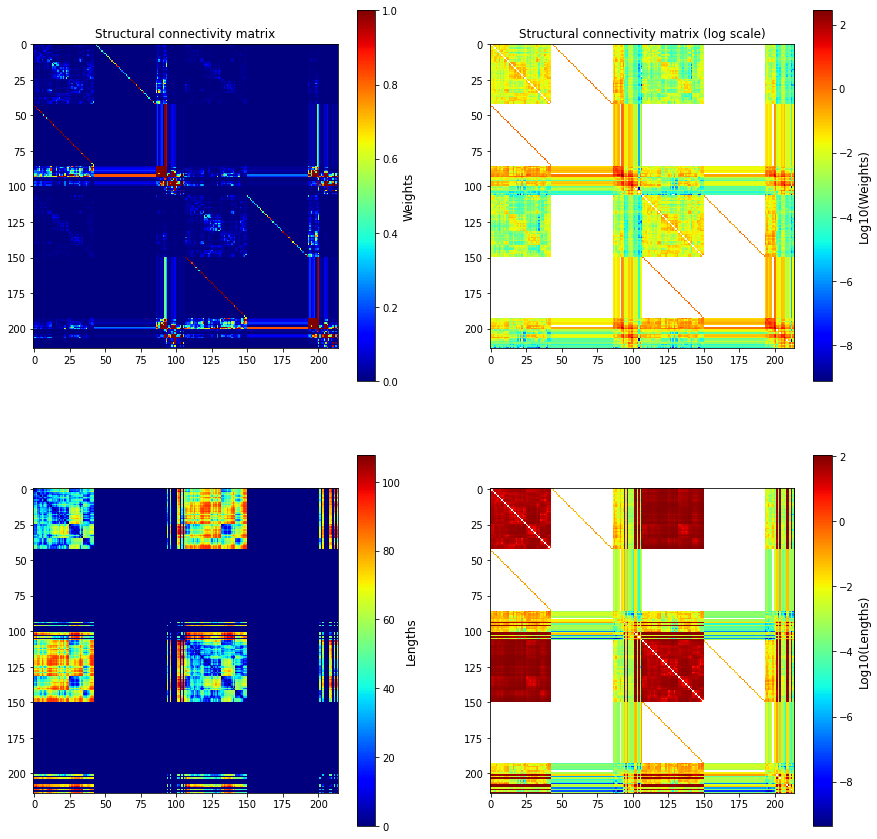

In [16]:

# Plot the resulting connectivity weights at linear and log scale
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(15, 15))
cs_lin = axes[0, 0].imshow(final_connectivity.weights, cmap='jet', aspect='equal', interpolation='none', vmax=1)
axes[0, 0].set_title('Structural connectivity matrix', fontsize=12)
axcb_lin = plt.colorbar(cs_lin, ax=axes[0, 0])
axcb_lin.set_label('Weights', fontsize=12)

cs_log = axes[0, 1].imshow(np.log10(final_connectivity.weights), cmap='jet', aspect='equal', interpolation='none')
axes[0, 1].set_title('Structural connectivity matrix (log scale)', fontsize=12)
axcb_log = plt.colorbar(cs_log, ax=axes[0, 1])
axcb_log.set_label('Log10(Weights)', fontsize=12)


ls_lin = axes[1, 0].imshow(final_connectivity.tract_lengths, cmap='jet', aspect='equal', interpolation='none')
axcb_lin = plt.colorbar(ls_lin, ax=axes[1, 0])
axcb_lin.set_label('Lengths', fontsize=12)

ls_log = axes[1, 1].imshow(np.log10(final_connectivity.tract_lengths), cmap='jet', aspect='equal', interpolation='none')
axcb_log = plt.colorbar(ls_log, ax=axes[1, 1])
axcb_log.set_label('Log10(Lengths)', fontsize=12)




# Plot the resulting connectivity weights and tract lengths beween Isocortex and Specific Thalamic Nuclei


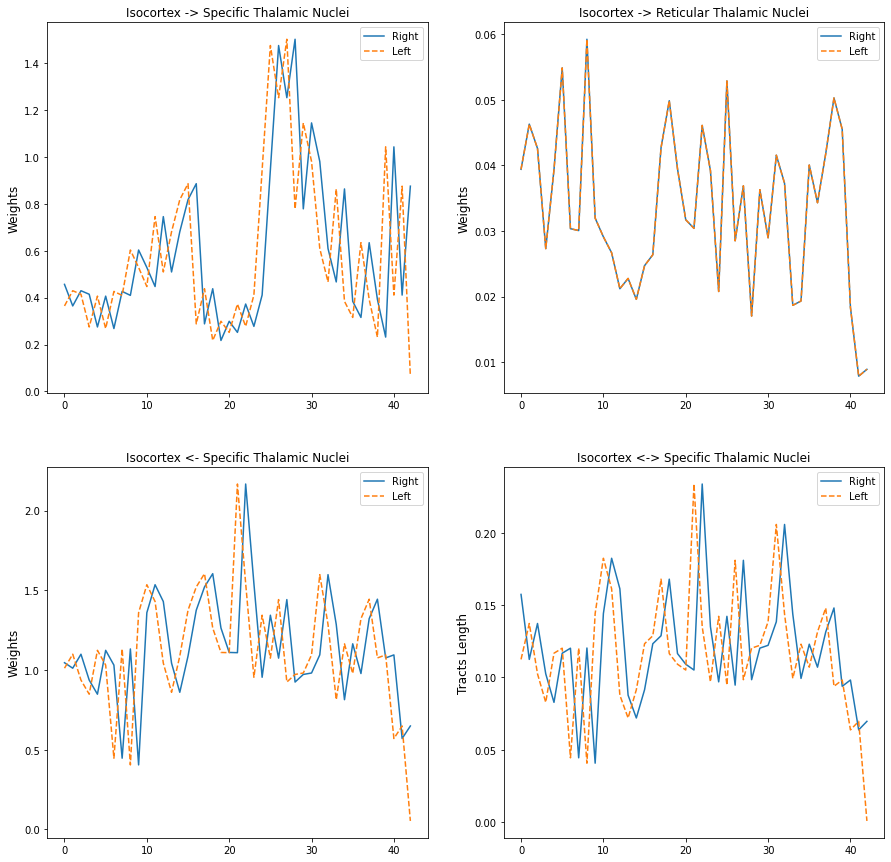

In [17]:

fig, axes = plt.subplots(2, 2, figsize=(15, 15))
cs_spec_R = axes[0, 0].plot(final_connectivity.weights[final_crtx_inds_R, final_spec_thal_inds_R], "-", label="Right")
cs_spec_L = axes[0, 0].plot(final_connectivity.weights[final_crtx_inds_L, final_spec_thal_inds_L], "--", label="Left")
axes[0, 0].set_title('Isocortex -> Specific Thalamic Nuclei', fontsize=12)
axes[0, 0].set_ylabel('Weights', fontsize=12)
axes[0, 0].legend()

cs_rtn_R = axes[0, 1].plot(crtx_to_rtn_conns[0, :43], "-", label="Right")
cs_rtn_L = axes[0, 1].plot(crtx_to_rtn_conns[1, 43:], "--", label="Left")
axes[0, 1].set_title('Isocortex -> Reticular Thalamic Nuclei', fontsize=12)
axes[0, 1].set_ylabel('Weights', fontsize=12)
axes[0, 1].legend()

cs_lin_R = axes[1, 0].plot(final_connectivity.weights[final_spec_thal_inds_R, final_crtx_inds_R], "-", label="Right")
cs_lin_L = axes[1, 0].plot(final_connectivity.weights[final_spec_thal_inds_L, final_crtx_inds_L], "--", label="Left")
axes[1, 0].set_title('Isocortex <- Specific Thalamic Nuclei', fontsize=12)
axes[1, 0].set_ylabel('Weights', fontsize=12)
axes[1, 0].legend()


tl_lin_R = axes[1, 1].plot(final_connectivity.tract_lengths[final_spec_thal_inds_R, final_crtx_inds_R], "-", label="Right")
tl_lin_L = axes[1, 1].plot(final_connectivity.tract_lengths[final_spec_thal_inds_L, final_crtx_inds_L], "--", label="Left")
axes[1, 1].set_title('Isocortex <-> Specific Thalamic Nuclei', fontsize=12)
axes[1, 1].set_ylabel('Tracts Length', fontsize=12)
axes[1, 1].legend()



# Construct useful indices

In [18]:
inds = {}
inds["crtx"] = []
inds["m1"] = []
inds["s1brl"] = []
inds["supcol"] = []
inds["facial"] = []
inds["trigeminal"] = []
inds["ponssens_trigeminal"] = []
inds["ponssens"] = []
inds["ponsmotor"] = []
inds["thal"] = []
inds["thalspec"] = []
inds["m1thal"] = []
inds["s1brlthal"] = []
inds["ansilob"] = []
inds["dentate"] = []
inds["interposed"] = []
inds["oliv"] = []
inds['cereb_nuclei'] = []
inds['cereb_crtx'] = []
for iR, (reg, lbl) in enumerate(zip(final_connectivity.region_labels, final_major_structs_labels)):
    if "Isocortex" in lbl:
        inds["crtx"].append(iR)
    if "Primary motor area" in reg and "Specific" not in reg:
        inds["m1"].append(iR)
    if "barrel" in reg and "Specific" not in reg:
        inds["s1brl"].append(iR)
    if "Superior colliculus, motor related" in reg:
        inds["supcol"].append(iR)
    if "Primary motor area" in reg and "Specific" in reg:
        inds["m1thal"].append(iR)
    if "barrel" in reg and "Specific" in reg:
        inds["s1brlthal"].append(iR)
    if "Superior colliculus, motor related" in reg:
        inds["supcol"].append(iR)
    if "Facial" in reg:
        inds["facial"] .append(iR)
    if "Spinal nucleus of the trigeminal" in reg:
        inds["trigeminal"].append(iR)
    if "Principal sensory nucleus of the trigeminal" in reg:
        inds["ponssens_trigeminal"] .append(iR)
    if "Pons Sensory" in lbl:
        inds["ponssens"] .append(iR)
    if "Pons Motor" in lbl:
        inds["ponsmotor"].append(iR)
    if "Nonspecific Thalamus" in lbl:
        inds["thal"].append(iR)
    if "Specific Thalamus" in lbl:
        inds["thalspec"].append(iR)
    if "Ansiform lobule" in reg:
        inds["ansilob"].append(iR)
    elif "Cerebellar Cortex" in lbl:
        inds['cereb_crtx'].append(iR)
    if "Dentate nucleus" in reg:
        inds["dentate"].append(iR)
    if "Interposed nucleus" in reg:
        inds["interposed"].append(iR)
    elif "Cerebellar Nuclei" in lbl:
        inds['cereb_nuclei'].append(iR)
    if "Inferior olivary complex" in reg:
        inds["oliv"].append(iR)

inds["m1s1brl"] = inds["m1"]  + inds["s1brl"]
inds["sens"] = inds["trigeminal"]  + inds["ponssens_trigeminal"] + inds["s1brlthal"]
inds["motor"] = inds["m1thal"] + inds["facial"]  # inds["supcol"]  + 
inds["cereb"] = inds["ansilob"] + inds["dentate"] + inds["interposed"] + inds["oliv"]
inds['cereb_merged'] = inds['cereb_nuclei'] + inds['cereb_crtx']
allspecial = inds["m1s1brl"] + inds["motor"] + inds["sens"] + inds["thal"] + inds["cereb"]
for key, val in inds.items():
    inds[key] = np.array(val)

print("ROIs:\n", final_connectivity.region_labels[allspecial])



ROIs:
 ['Right Primary motor area' 'Left Primary motor area'
 'Right Primary somatosensory area, barrel field'
 'Left Primary somatosensory area, barrel field'
 'Right Specific Thalamus to Primary motor area'
 'Left Specific Thalamus to Primary motor area'
 'Right Facial motor nucleus' 'Left Facial motor nucleus'
 'Right Spinal nucleus of the trigeminal'
 'Left Spinal nucleus of the trigeminal'
 'Right Principal sensory nucleus of the trigeminal'
 'Left Principal sensory nucleus of the trigeminal'
 'Right Specific Thalamus to Primary somatosensory area, barrel field'
 'Left Specific Thalamus to Primary somatosensory area, barrel field'
 'Right Nonspecific Thalamus' 'Left Nonspecific Thalamus'
 'Right Ansiform lobule' 'Left Ansiform lobule' 'Right Interposed nucleus'
 'Left Interposed nucleus' 'Right Inferior olivary complex'
 'Left Inferior olivary complex']


In [19]:
print("Major structures:\n", np.unique(final_major_structs_labels))

Major structures:
 ['Left Cerebellar Cortex' 'Left Cerebellar Nuclei'
 'Left Cortical Subplate' 'Left Hippocampal Formation' 'Left Hypothalamus'
 'Left Isocortex' 'Left Medulla' 'Left Midbrain'
 'Left Nonspecific Thalamus' 'Left Olfactory Areas' 'Left Pallidum'
 'Left Pons Behavioral' 'Left Pons Motor' 'Left Pons Sensory'
 'Left Specific Thalamus' 'Left Spinal nucleus of the trigeminal'
 'Left Striatum' 'Right Cerebellar Cortex' 'Right Cerebellar Nuclei'
 'Right Cortical Subplate' 'Right Hippocampal Formation'
 'Right Hypothalamus' 'Right Isocortex' 'Right Medulla' 'Right Midbrain'
 'Right Nonspecific Thalamus' 'Right Olfactory Areas' 'Right Pallidum'
 'Right Pons Behavioral' 'Right Pons Motor' 'Right Pons Sensory'
 'Right Specific Thalamus' 'Right Spinal nucleus of the trigeminal'
 'Right Striatum']


# Writing files for Connectivity with summarized subcortical structures and Specific Thalami

In [20]:
# Write the resulting connectivity to .h5 TVB compatible file...
write_all_files(conn_name="Connectivity", conn_type="SummedSubcortical_Thals")


Writing files for SummedSubcortical Connectivity...
Writing Connectivity_wavCntrs_TLwav_SummedSubcortical_Thals.h5
Writing major_structs_labels_SummedSubcortical_Thals.npy...
Writing voxel_count_SummedSubcortical_Thals.npy...
Writing inds_SummedSubcortical_Thals.npy...


# Print out statistics of final regions' sizes and connectivity

In [21]:
from six import string_types
from collections import OrderedDict
from tvb.contrib.scripts.utils.data_structures_utils import is_integer, is_float
from examples.tvb_nest.notebooks.cerebellum.utils import print_conn
    

def _maxrow(maxrow, weights):
    if maxrow < 1:
        cum = np.maximum(maxrow, 0.1)
        maxrow_label = "%g%%" % (100*cum)
        weights_sum = 0.0
        weights_total = weights.sum()
        maxrow = 0
        for weight in weights:
            maxrow += 1
            weights_sum += weight
            if weights_sum / weights_total >= cum:
                break
    else:
        maxrow = int(maxrow)
        maxrow_label = "%d" % maxrow
    return maxrow, maxrow_label


def print_weights_from(label, inds, region_labels, weights, maxrow=0.9):
    for iH, hemi in enumerate(["Right", "Left"]):
        arginds = np.argsort(weights[inds[iH], :])[::-1]
        out_maxrow, maxrow_label = _maxrow(maxrow, weights[inds[iH], arginds].squeeze())
        d = OrderedDict()
        d[("Region", 55)] = ["%d.%s" % (iR, region_labels[iR]) for iR in arginds]
        d[("Weight", 30)] = weights[inds[iH], arginds]
        d[("Total weights to", 30)] = np.nansum(weights[arginds], axis=1)
        print_conn(d, prnt="\nStronger %s connections from %s %s to:\n" % (maxrow_label, hemi, label), 
                   maxrow=out_maxrow, printit=True);
    
    
def print_weights_to(label, inds, region_labels, weights, maxrow=0.9):
    for iH, hemi in enumerate(["Right", "Left"]):
        arginds = np.argsort(weights[:, inds[iH]])[::-1]
        out_maxrow, maxrow_label = _maxrow(maxrow, weights[inds[iH], arginds].squeeze())
        d = OrderedDict()
        d[("Region", 55)] = ["%d.%s" % (iR, region_labels[iR]) for iR in arginds]
        d[("Weight", 30)] = weights[arginds, inds[iH]]
        d[("Total weights from", 30)] = np.nansum(weights[:, arginds], axis=0)
        print_conn(d, prnt="\nStronger %s connections to %s %s from:\n" % (maxrow_label, hemi, label), 
                   maxrow=out_maxrow, printit=True);
        

In [22]:
d = OrderedDict()
d[("Region", 55)] = ["%d.%s" % (iR, reg[:50]) for iR, reg in enumerate(final_connectivity.region_labels)]
d[("Major Structure", 30)] = final_major_structs_labels
d[("Voxels", 10)] = final_voxel_count
d[("Total weights to/from", 21)] = np.array(["%0.3f/%0.3f" % ( wt, wf) 
                                             for wt, wf in zip(np.nansum(final_connectivity.weights, axis=1), 
                                                               np.nansum(final_connectivity.weights, axis=0))])
print_conn(d, prnt="", printit=True);

Region.................................................Major Structure...............Voxels....Total weights to/from
--------------------------------------------------------------------------------------------------------------------
0.Right Frontal pole, cerebral cortex..................Right Isocortex...............514.......3.107/5.948..........
1.Right Primary motor area.............................Right Isocortex...............11760.....1.855/6.174..........
2.Right Secondary motor area...........................Right Isocortex...............10098.....2.315/6.759..........
3.Right Primary somatosensory area, nose...............Right Isocortex...............1358......1.197/5.138..........
4.Right Primary somatosensory area, barrel field.......Right Isocortex...............10306.....1.371/6.229..........
5.Right Primary somatosensory area, lower limb.........Right Isocortex...............3254......1.829/5.456..........
6.Right Primary somatosensory area, mouth..............Right Iso

In [23]:
print("SENSORY PATHWAY:\n")
print_weights_from("Spinal nucleus of the trigeminal", inds["trigeminal"], 
                   final_connectivity.region_labels, final_connectivity.weights, maxrow=0.9)
print_weights_to("Principal sensory nucleus of the trigeminal", inds["ponssens_trigeminal"], 
                 final_connectivity.region_labels, final_connectivity.weights, maxrow=0.9)
print_weights_from("Principal sensory nucleus of the trigeminal", inds["ponssens_trigeminal"], 
                   final_connectivity.region_labels, final_connectivity.weights, maxrow=0.9)
print_weights_to("Ansiform lobule", inds["ansilob"], 
                final_connectivity.region_labels, final_connectivity.weights, maxrow=0.95)

print("\n\n\nMOTOR PATHWAY:\n")
print_weights_from("Primary motor area", inds["m1"], final_connectivity.region_labels, final_connectivity.weights, maxrow=0.9)
# print_weights_to("Superior colliculus, motor related", inds["supcol"], final_connectivity.region_labels, final_connectivity.weights, maxrow=10)
# print_weights_from("Superior colliculus, motor related", inds["supcol"], final_connectivity.region_labels, final_connectivity.weights, maxrow=10)
print_weights_to("Facial motor nucleus", inds["facial"], final_connectivity.region_labels, final_connectivity.weights, maxrow=0.9)



SENSORY PATHWAY:


Stronger 90% connections from Right Spinal nucleus of the trigeminal to:
Region.................................................Weight........................Total weights to..............
-------------------------------------------------------------------------------------------------------------------
99.Right Medulla.......................................3.88545.......................241.373.......................
206.Left Medulla.......................................1.11788.......................241.373.......................
100.Right Spinal nucleus of the trigeminal.............0.529612......................7.94454.......................
97.Right Pons Motor....................................0.296719......................111.275.......................
200.Left Midbrain......................................0.278015......................429.195.......................
204.Left Pons Motor....................................0.136143......................111.275....

# Brain network graph

In [24]:
# import networkx as nx  # https://networkx.org/
# from mpl_toolkits.mplot3d import Axes3D


# def conn_to_graph(conn, major_structs_labels, voxel_count):
    
#     G = nx.DiGraph()
#     # G.add_edge('A', 'B', weight=4)
#     nodes = []
#     for iR, (reg, centre, msl, vc) in enumerate(zip(conn.region_labels, conn.centres, 
#                                                     major_structs_labels, voxel_count)):
#         nodes.append(reg)
#         G.add_node(nodes[-1], ind=iR, centre=centre, major_structure_label=msl, vc=vc)
        
#     for iR1, reg1 in enumerate(nodes):
#         for iR2, reg2 in enumerate(nodes):
#             G.add_edge(reg1, reg2, 
#                        weight=conn.weights[iR2, iR1], 
#                        distance=1.0/conn.weights[iR2, iR1] if conn.weights[iR2, iR1] > 0 else np.inf, 
#                        tract_length=conn.tract_lengths[iR2, iR1])
        
#     return G
        
    

# def plot_G_conn_3D(G, nodes_kwgs={'s': 100, 'ec':"w"}, 
#                    edges_kwgs={'color':"tab:gray", 'alpha': 0.01}, show=True):

#     node_centres = nx.get_node_attributes(G, "centre")

#     # 3d layout
#     pos = nx.rescale_layout_dict(node_centres)

#     # Extract node and edge positions from the layout
#     node_xyz = np.array([pos[v] for v in sorted(G)])
#     edge_xyz = np.array([(pos[u], pos[v]) for u, v in G.edges()])

#     # Create the 3D figure
#     fig = plt.figure(figsize=(15, 15))
#     ax = fig.add_subplot(111, projection="3d")

#     # Plot the nodes - alpha is scaled by "depth" automatically
#     ax.scatter(*node_xyz.T, **nodes_kwgs)

#     # Plot the edges
#     for vizedge in edge_xyz:
#         ax.plot(*vizedge.T, **edges_kwgs)


#     def _format_axes(ax):
#         """Visualization options for the 3D axes."""
#         # Turn gridlines off
#         ax.grid(False)
#         # Suppress tick labels
#         for dim in (ax.xaxis, ax.yaxis, ax.zaxis):
#             dim.set_ticks([])
#         # Set axes labels
#         ax.set_xlabel("x")
#         ax.set_ylabel("y")
#         ax.set_zlabel("z")


#     _format_axes(ax)
#     fig.tight_layout()
    
#     if show:
#         plt.show()
    
#     return fig, ax


In [25]:
# G = conn_to_graph(final_connectivity, final_major_structs_labels, final_voxel_count)
# source = "Right Spinal nucleus of the trigeminal"
# target = 'Right Ansiform lobule' 

# print(G.nodes())

# sp = nx.shortest_path(G, source, target, weight='distance')  # distance = 1/weight
# print("Shortest Path:\n", sp)

# spl = nx.shortest_path_length(G, source, target, weight='distance') 
# print("Shortest Path Length:\n", spl)

# w = 1.0 / spl / (len(sp) - 1)
# print("Shortest Path Weight = 1.0 / ShortestPathLength / (len(ShortestPath)-1):\n", w)


# # For interactive plotting:
# %matplotlib notebook 

# plot_G_conn_3D(G)

In [26]:
# # Summarize also the Cerebellar Cortices and Nuclei:
# major_structures_to_merge = ['Cerebellar Cortex', "Cerebellar Nuclei"]
# exclude_regions={}

# # For bilateral merging:
# major_structures_to_merge, exclude_regions = unilateral_to_bilateral(major_structures_to_merge, exclude_regions)

# merged_cereb_conn, merged_cereb_major_structs_labels, merged_cereb_voxel_count = \
#     merge_major_structures(final_connectivity, 
#                            major_structures_to_merge,
#                            final_major_structs_labels, final_voxel_count,
#                            exclude_regions=exclude_regions, weight_fun=np.nansum)

# inds = {}
# inds["crtx"] = []
# inds["m1"] = []
# inds["s1brl"] = []
# inds["supcol"] = []
# inds["facial"] = []
# inds["trigeminal"] = []
# inds["ponssens_trigeminal"] = []
# inds["ponssens"] = []
# inds["ponsmotor"] = []
# inds["thal"] = []
# inds["thalspec"] = []
# inds["m1thal"] = []
# inds["s1brlthal"] = []
# inds["cerebcrtx"] = []
# inds["cerebnucleus"] = []
# inds["oliv"] = []
# for iR, (reg, lbl) in enumerate(zip(merged_cereb_conn.region_labels, merged_cereb_major_structs_labels)):
#     if "Isocortex" in lbl:
#         inds["crtx"].append(iR)
#     if "Primary motor area" in reg and "Specific" not in reg:
#         inds["m1"].append(iR)
#     if "barrel" in reg and "Specific" not in reg:
#         inds["s1brl"].append(iR)
#     if "Superior colliculus, motor related" in reg:
#         inds["supcol"].append(iR)
#     if "Primary motor area" in reg and "Specific" in reg:
#         inds["m1thal"].append(iR)
#     if "barrel" in reg and "Specific" in reg:
#         inds["s1brlthal"].append(iR)
#     if "Superior colliculus, motor related" in reg:
#         inds["supcol"].append(iR)
#     if "Facial" in reg:
#         inds["facial"] .append(iR)
#     if "Spinal nucleus of the trigeminal" in reg:
#         inds["trigeminal"].append(iR)
#     if "Principal sensory nucleus of the trigeminal" in reg:
#         inds["ponssens_trigeminal"] .append(iR)
#     if "Pons Sensory" in lbl:
#         inds["ponssens"] .append(iR)
#     if "Pons Motor" in lbl:
#         inds["ponsmotor"].append(iR)
#     if "Nonspecific Thalamus" in lbl:
#         inds["thal"].append(iR)
#     if "Specific Thalamus" in lbl:
#         inds["thalspec"].append(iR)
#     if "Cerebellar Cortex" in reg:
#         inds["cerebcrtx"].append(iR)
#     if "Cerebellar Nuclei" in reg:
#         inds["cerebnucleus"].append(iR)
#     if "Inferior olivary complex" in reg:
#         inds["oliv"].append(iR)
# inds["m1s1brl"] = inds["m1"]  + inds["s1brl"]
# inds["sens"] = inds["trigeminal"]  + inds["ponssens_trigeminal"] + inds["s1brlthal"]
# inds["motor"] = inds["m1thal"] + inds["facial"]  # inds["supcol"]  + 
# inds["cereb"] = inds["cerebcrtx"] + inds["cerebnucleus"] + inds["oliv"]
# allspecial = inds["m1s1brl"] + inds["motor"] + inds["sens"] + inds["thal"] + inds["cereb"]
# for key, val in inds.items():
#     inds[key] = np.array(val)
# print(merged_cereb_conn.region_labels[allspecial])

In [27]:
# # Write the resulting connectivity to .h5 TVB compatible file...
# write_connectivity_to_h5_file(merged_cereb_conn, "Connectivity_SummedSubcortical_Thals_SummedCereb.h5")
# # ... along with the corresponding mapping from regions to major structures.
# np.save("major_structs_labels_SummedSubcortical_Thals_SummedCereb.npy", merged_cereb_major_structs_labels)
# np.save("voxel_count_SummedSubcortical_Thals_SummedCereb.npy", merged_cereb_voxel_count)
# np.save("inds_SummedSubcortical_Thals_SummedCereb.npy", inds)
